# Import libraries

In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import gzip
import shutil
import glob
import folium
import matplotlib.patches as mpatches
from adjustText import adjust_text

In [2]:
from config import *
LODESYear = '20'

# Load data

In [3]:
#Annual Resident Population Estimates for Metropolitan/Micropolitan Statistical Areas (https://www.census.gov/data/tables/time-series/demo/popest/2020s-total-metro-and-micro-statistical-areas.html first dataset)

popData = pd.read_csv(dataFolder + "/cbsa-est2022.csv", encoding="latin-1")
popData = popData[['CBSA', 'NAME', 'LSAD', 'POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022']]
popData

,CBSA,NAME,LSAD,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022
0,10180,"Abilene, TX",Metropolitan Statistical Area,176866,177829,179308
1,10180,"Callahan County, TX",County or equivalent,13744,14078,14210
2,10180,"Jones County, TX",County or equivalent,19678,19809,19935
3,10180,"Taylor County, TX",County or equivalent,143444,143942,145163
4,10420,"Akron, OH",Metropolitan Statistical Area,701625,696225,697627
...,...,...,...,...,...,...
2794,49460,"Yankton County, SD",County or equivalent,23282,23334,23373
2795,49780,"Zanesville, OH",Micropolitan Statistical Area,86450,86574,86113
2796,49780,"Muskingum County, OH",County or equivalent,86450,86574,86113
2797,49820,"Zapata, TX",Micropolitan Statistical Area,13874,13893,13849


In [4]:
#Load Core Based Statistical Areas (https://catalog.data.gov/dataset/tiger-line-shapefile-2019-nation-u-s-current-metropolitan-statistical-area-micropolitan-statist)
#CRS 3857: https://epsg.io/3857

CBSAs = geopandas.read_file(dataFolder + "/tl_2019_us_cbsa.zip").to_crs(3857)
CBSAs = CBSAs[['CBSAFP', 'NAME', 'geometry']]
CBSAs['CBSAFP'] = CBSAs['CBSAFP'].astype(int)
CBSAs

,CBSAFP,NAME,geometry
0,12020,"Athens-Clarke County, GA","POLYGON ((-9299339.399 4024225.385, -9298722.4..."
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","POLYGON ((-9499808.416 3982318.514, -9499830.0..."
2,12100,"Atlantic City-Hammonton, NJ","POLYGON ((-8333014.948 4782122.394, -8333009.7..."
3,12120,"Atmore, AL","POLYGON ((-9753303.463 3638074.432, -9753303.2..."
4,12140,"Auburn, IN","POLYGON ((-9483635.192 5068556.085, -9483636.4..."
...,...,...,...
933,49060,"Winfield, KS","POLYGON ((-10814782.844 4481524.994, -10814783..."
934,49080,"Winnemucca, NV","POLYGON ((-13233024.775 5006594.818, -13233215..."
935,49100,"Winona, MN","POLYGON ((-10250133.062 5468589.383, -10250142..."
936,49180,"Winston-Salem, NC","POLYGON ((-8955841.577 4336663.225, -8955841.5..."


In [5]:
#Load states shapefile (for plotting) (https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html under States)

statesShp = geopandas.read_file(dataFolder + "/cb_2018_us_state_500k.zip").to_crs(3857)
statesShp = statesShp[['GEOID', 'STUSPS', 'NAME', 'geometry']]

def plotUS():
    ax = statesShp.plot(figsize=(20, 10), color='#e4e4e4', edgecolor='black', linewidth=2)
    ax.axis('equal')
    plt.xlim(-1.5e7, -0.7e7)
    plt.ylim(2.5e6, 7e6)
    return ax

def plotTX():
    ax = statesShp[statesShp['STUSPS'] == 'TX'].plot(figsize=(10, 10), color='#e4e4e4', edgecolor='black', linewidth=2)
    ax.axis('equal')
    plt.xlim(-1.23e7, -1e7)
    plt.ylim(2.5e6, 5e6)
    return ax

def plotDFW():
    ax = statesShp[statesShp['STUSPS'] == 'TX'].plot(figsize=(12, 10), color='#e4e4e4', edgecolor='black', linewidth=2)
    ax.axis('equal')
    plt.xlim(-1.12e7, -1.02e7)
    plt.ylim(3.7e6, 4.1e6)
    return ax

<AxesSubplot:>

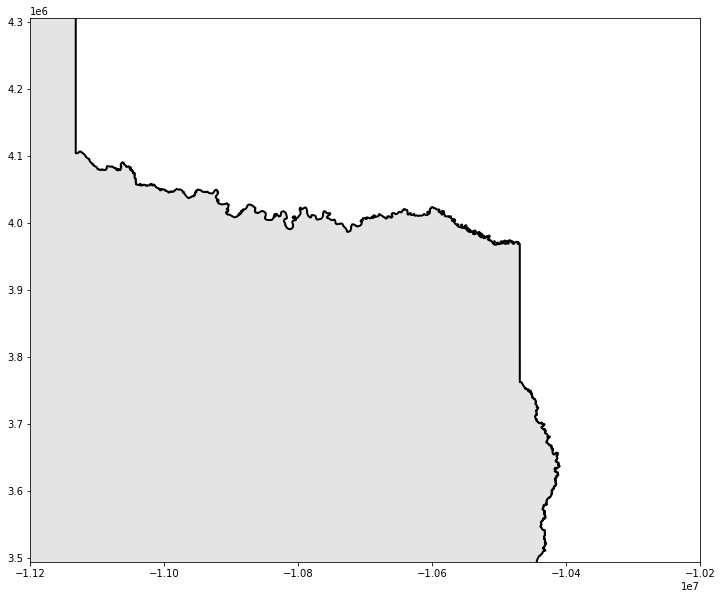

In [6]:
plotDFW()

In [7]:
#Download LODES data for orgin-destination travel (how many people commute from place X to place Y)

states = ['al', 'ak', 'ar', 'az', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'hi', 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la',
          'me', 'md', 'ma', 'mi', 'mn', 'mo', 'ms', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny', 'nc', 'nd', 'oh', 'ok',
          'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy']

base_url = "https://lehd.ces.census.gov/data/lodes/LODES8/"

folder_name = dataFolder + "/LODES" + LODESYear

if not os.path.exists(folder_name):
    os.makedirs(folder_name)

for state in states:
    if state == 'ak':
        file_url = base_url + state + "/od/" + state + "_od_main_JT00_2016.csv.gz"
        file_name = state + "_od_main_JT00_2016.csv.gz"
    elif state == 'ar':
        file_url = base_url + state + "/od/" + state + "_od_main_JT00_2018.csv.gz"
        file_name = state + "_od_main_JT00_2018.csv.gz"
    elif state == 'ms':
        file_url = base_url + state + "/od/" + state + "_od_main_JT00_2018.csv.gz"
        file_name = state + "_od_main_JT00_2018.csv.gz"
    else:
        file_url = base_url + state + "/od/" + state + "_od_main_JT00_20" + LODESYear + ".csv.gz"
        file_name = state + "_od_main_JT00_20" + LODESYear + ".csv.gz"
    
    file_path = os.path.join(folder_name, file_name)
    file_path_csv = file_path[:-3]
    if os.path.exists(file_path_csv):
        print("File aleady exists", file_path_csv)
        continue #Do not re-download
    
    print("Downloading", file_name)
    response = requests.get(file_url)
    
    with open(file_path, 'wb') as file:
        file.write(response.content)
    print("Download complete.")
    
    # Unzip the file
    unzipped_file_name = file_name[:-3]  # Remove '.gz' extension
    with gzip.open(file_path, 'rb') as f_in:
        with open(os.path.join(folder_name, unzipped_file_name), 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    print("Unzipped", unzipped_file_name)
    os.remove(file_path)
    print("Deleted", file_name)

File aleady exists /work/group/egodat/reu23_clark/temp/data//LODES20/al_od_main_JT00_2020.csv
File aleady exists /work/group/egodat/reu23_clark/temp/data//LODES20/ak_od_main_JT00_2016.csv
File aleady exists /work/group/egodat/reu23_clark/temp/data//LODES20/ar_od_main_JT00_2018.csv
File aleady exists /work/group/egodat/reu23_clark/temp/data//LODES20/az_od_main_JT00_2020.csv
File aleady exists /work/group/egodat/reu23_clark/temp/data//LODES20/ca_od_main_JT00_2020.csv
File aleady exists /work/group/egodat/reu23_clark/temp/data//LODES20/co_od_main_JT00_2020.csv
File aleady exists /work/group/egodat/reu23_clark/temp/data//LODES20/ct_od_main_JT00_2020.csv
File aleady exists /work/group/egodat/reu23_clark/temp/data//LODES20/de_od_main_JT00_2020.csv
File aleady exists /work/group/egodat/reu23_clark/temp/data//LODES20/fl_od_main_JT00_2020.csv
File aleady exists /work/group/egodat/reu23_clark/temp/data//LODES20/ga_od_main_JT00_2020.csv
File aleady exists /work/group/egodat/reu23_clark/temp/data/

In [8]:
#Download crosswalk data (which CBSAs contain which blocks/block groups)

base_url = "https://lehd.ces.census.gov/data/lodes/LODES8/"
folder_name = dataFolder + "/LODES_XWALK"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
for state in states:
    
    file_url = base_url + state + "/" + state + "_xwalk.csv.gz"
    file_name = state + "_xwalk.csv.gz"
    
    
    file_path = os.path.join(folder_name, file_name)
    file_path_csv = file_path[:-3]
    if os.path.exists(file_path_csv):
        print("File aleady exists", file_path_csv)
        continue #Do not re-download
    
    print("Downloading", file_name)
    response = requests.get(file_url)
    
    with open(file_path, 'wb') as file:
        file.write(response.content)
    
    print("Download complete.")
    
    unzipped_file_name = file_name[:-3]
    with gzip.open(file_path, 'rb') as f_in:
        with open(os.path.join(folder_name, unzipped_file_name), 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    print("Unzipped", unzipped_file_name)
    
    os.remove(file_path)
    
    print("Deleted", file_name)

File aleady exists /work/group/egodat/reu23_clark/temp/data//LODES_XWALK/al_xwalk.csv
File aleady exists /work/group/egodat/reu23_clark/temp/data//LODES_XWALK/ak_xwalk.csv
File aleady exists /work/group/egodat/reu23_clark/temp/data//LODES_XWALK/ar_xwalk.csv
File aleady exists /work/group/egodat/reu23_clark/temp/data//LODES_XWALK/az_xwalk.csv
File aleady exists /work/group/egodat/reu23_clark/temp/data//LODES_XWALK/ca_xwalk.csv
File aleady exists /work/group/egodat/reu23_clark/temp/data//LODES_XWALK/co_xwalk.csv
File aleady exists /work/group/egodat/reu23_clark/temp/data//LODES_XWALK/ct_xwalk.csv
File aleady exists /work/group/egodat/reu23_clark/temp/data//LODES_XWALK/de_xwalk.csv
File aleady exists /work/group/egodat/reu23_clark/temp/data//LODES_XWALK/fl_xwalk.csv
File aleady exists /work/group/egodat/reu23_clark/temp/data//LODES_XWALK/ga_xwalk.csv
File aleady exists /work/group/egodat/reu23_clark/temp/data//LODES_XWALK/hi_xwalk.csv
File aleady exists /work/group/egodat/reu23_clark/temp

In [9]:
#Load orgin-destination data (loops through each state)

if os.path.exists(dataFolder + "/od_data_combined" + LODESYear + ".pkl"):
    print("Loading cached file...")
    odData = pd.read_pickle(dataFolder + "/od_data_combined" + LODESYear + ".pkl")
else:
    stateData = []

    for path in glob.glob(dataFolder + "/LODES" + LODESYear + "/*_od_main_JT00_20*.csv"):
        print(".", end="")
        odData = pd.read_csv(path)
        odData = odData[['w_geocode', 'h_geocode', 'S000']]
        stateData.append(odData)

    odData = pd.concat(stateData)
    odData.to_pickle(dataFolder + "/od_data_combined" + LODESYear + ".pkl")
    odData
#.................................................

Loading cached file...


In [10]:
#Load crosswalk data

if os.path.exists(dataFolder + "/xwalk_data_combined.pkl"):
    print("Loading cached file...")
    xwalk = pd.read_pickle(dataFolder + "/xwalk_data_combined.pkl")
else:
    stateData = []

    for path in glob.glob(dataFolder + "/LODES_XWALK/*_xwalk.csv"):
        print(".", end="")
        xwalk = pd.read_csv(path, low_memory=False)
        xwalk = xwalk[['ctyname', 'bgrp', 'cbsa']]
        stateData.append(xwalk)

    xwalk = pd.concat(stateData)
    xwalk.to_pickle(dataFolder + "/xwalk_data_combined.pkl")
    xwalk
#.................................................

Loading cached file...


# Analysis

## Create OD count lookup table
How many people commuted from blockgroup x to blockgroup y = odTable[x, y]

In [11]:
#Extract block group code
odData['h_bgrp'] = (odData['h_geocode'] / 10**3).astype(int)
odData['w_bgrp'] = (odData['w_geocode'] / 10**3).astype(int)

In [12]:
#Lookup cbsa for blockgroup
if os.path.exists(dataFolder + "/od_table" + LODESYear + ".pkl"):
    print("Loading cached file...")
    odTable = pd.read_pickle(dataFolder + "/od_table" + LODESYear + ".pkl")
else:
    #Lookup table to make finding a blockgroup's cbsa fast
    bgrpToCbsa = xwalk.groupby('bgrp').first()['cbsa']
    bgrpToCbsa = dict(zip(bgrpToCbsa.index, bgrpToCbsa.values)) #Dict is faster for lookup

    odData['w_cbsa'] = odData['w_bgrp'].apply(lambda c: bgrpToCbsa[c])
    odData['h_cbsa'] = odData['h_bgrp'].apply(lambda c: bgrpToCbsa[c])
    odTable = odData.groupby(['h_cbsa', 'w_cbsa']).sum()['S000']
    odTable.to_pickle(dataFolder + "/od_table" + LODESYear + ".pkl")

odTable

Loading cached file...


h_cbsa  w_cbsa
10100   10100       15856.0
        15100         346.0
        26700         235.0
        33580         286.0
        38180         214.0
                    ...    
99999   49700        1361.0
        49740         135.0
        49780        1396.0
        49820          45.0
        99999     3503102.0
Name: S000, Length: 29665, dtype: float64

## Working population lookup table
How many people work in blockgroup x (and commute somewhere) = workingPop[x]

In [13]:
if os.path.exists(dataFolder + "/workingPop" + LODESYear + ".pkl"):
    print("Loading cached file...")
    workingPop = pd.read_pickle(dataFolder + "/workingPop" + LODESYear + ".pkl")
else:
    workingPop = odData.groupby(['h_cbsa']).sum()['S000']
    workingPop.to_pickle(dataFolder + "/workingPop" + LODESYear + ".pkl")

workingPop

Loading cached file...


h_cbsa
10100      19624.0
10140      28706.0
10180      66780.0
10220      15247.0
10300      32522.0
           ...    
49700      68007.0
49740      63974.0
49780      33194.0
49820       4216.0
99999    6432067.0
Name: S000, Length: 928, dtype: float64

## Main gdf table with data for every CBSA

In [14]:
popDataM = popData[((popData['LSAD'] == 'Metropolitan Statistical Area') | (popData['LSAD'] == 'Micropolitan Statistical Area'))]
popDataM = popDataM.drop(columns='NAME') #Do not need to store two copys of name

gdf = pd.merge(popDataM, CBSAs, left_on="CBSA", right_on="CBSAFP", how="inner")
gdf = gdf.drop(columns='CBSAFP') #No need for CBSAFP and CBSA
gdf = geopandas.GeoDataFrame(gdf)
gdf

,CBSA,LSAD,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,NAME,geometry
0,10180,Metropolitan Statistical Area,176866,177829,179308,"Abilene, TX","POLYGON ((-11148262.500 3832132.455, -11148249..."
1,10420,Metropolitan Statistical Area,701625,696225,697627,"Akron, OH","POLYGON ((-9060481.928 5063847.837, -9060475.5..."
2,10500,Metropolitan Statistical Area,148244,144922,145786,"Albany, GA","POLYGON ((-9400975.184 3713776.408, -9400980.6..."
3,10540,Metropolitan Statistical Area,128978,129948,130467,"Albany-Lebanon, OR","POLYGON ((-13720236.776 5551262.937, -13720393..."
4,10580,Metropolitan Statistical Area,899748,905369,904617,"Albany-Schenectady-Troy, NY","POLYGON ((-8247992.807 5305256.748, -8248085.6..."
...,...,...,...,...,...,...,...
921,49300,Micropolitan Statistical Area,116906,116129,116559,"Wooster, OH","POLYGON ((-9089178.853 5010653.858, -9088979.1..."
922,49380,Micropolitan Statistical Area,22207,22047,21947,"Worthington, MN","POLYGON ((-10627927.538 5441934.306, -10627791..."
923,49460,Micropolitan Statistical Area,23282,23334,23373,"Yankton, SD","POLYGON ((-10855702.126 5337734.746, -10853435..."
924,49780,Micropolitan Statistical Area,86450,86574,86113,"Zanesville, OH","POLYGON ((-9149881.580 4868949.855, -9149879.9..."


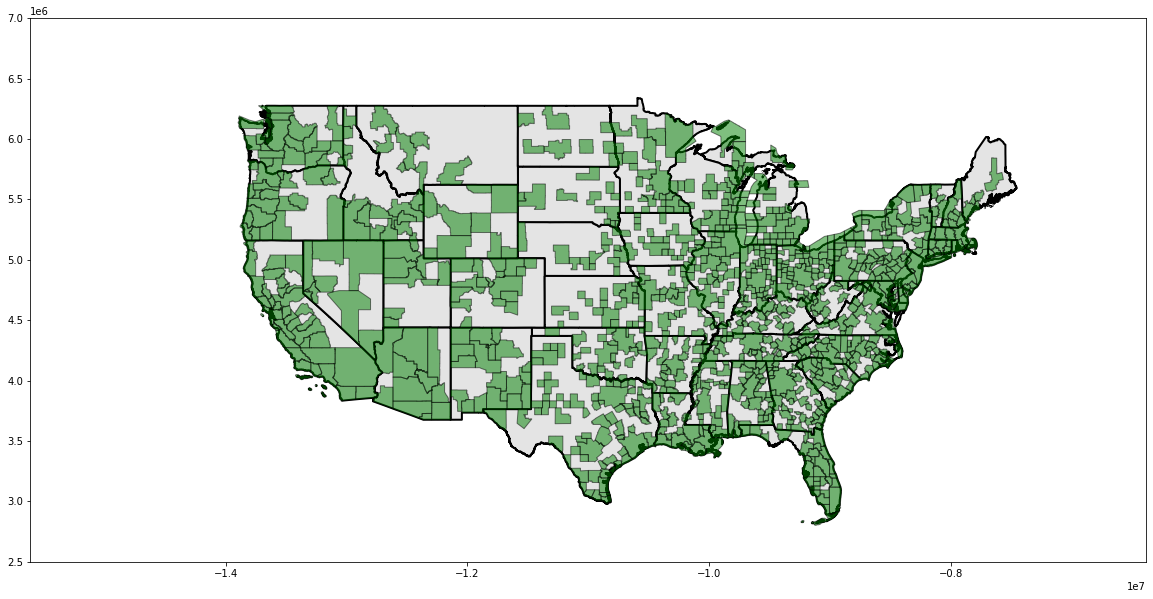

In [15]:
ax = plotUS()
gdf.plot(ax=ax, color="green", edgecolor="black", linewidth=1, alpha=0.5);

## Find large metro areas and small metro/micro areas

In [16]:
#Urban centers are Metropolitan Statistical Areas with population > 1,000,000
#Potential liminal places are Metropolitan/Micropolitan Statistical Areas with population < 100,000

gdf['metro'] = (gdf['POPESTIMATE2021'] > 1_000_000) & (gdf['LSAD'] == 'Metropolitan Statistical Area')
gdf['micro'] = (gdf['POPESTIMATE2021'] < 100_000) & ((gdf['LSAD'] == 'Metropolitan Statistical Area') | (gdf['LSAD'] == 'Micropolitan Statistical Area'))

print(gdf['metro'].sum(), "large metro areas")
print(gdf['micro'].sum(), "small metro/micro areas")

56 large metro areas
536 small metro/micro areas


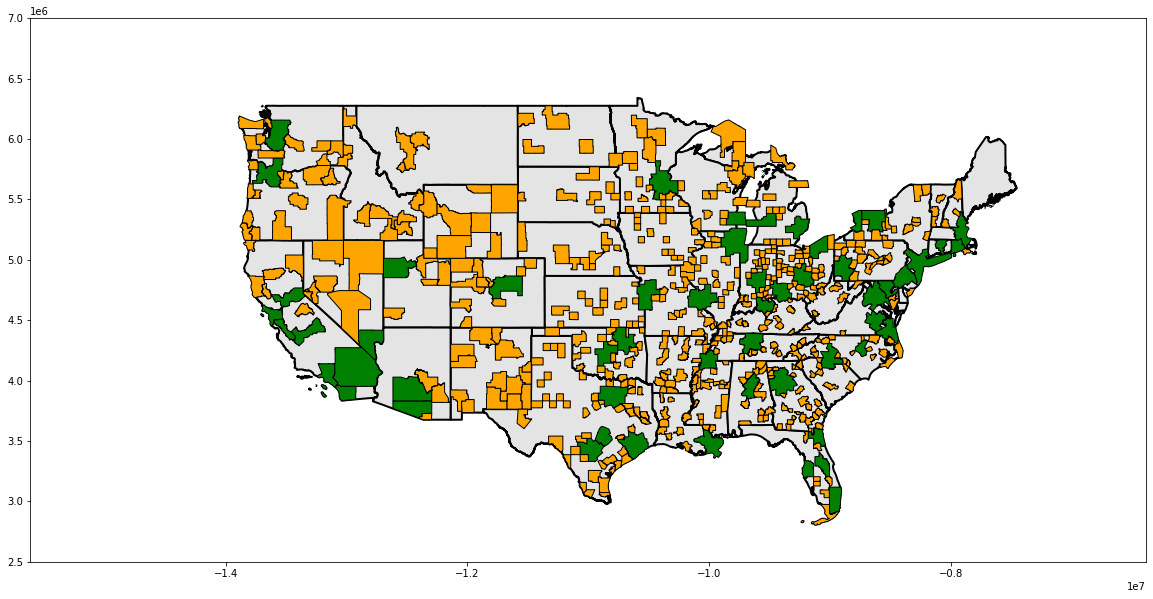

In [17]:
ax = plotUS()
gdf[gdf['metro']].plot(ax=ax, color="green", edgecolor="black", linewidth=1)
gdf[gdf['micro']].plot(ax=ax, color="orange", edgecolor="black", linewidth=1);

## 100Mi buffer around large metro areas

In [18]:
buffRad = 100 * 1609.34 #100Mi to m
gdf['buff'] = gdf.buffer(buffRad)

In [19]:
# For each area, check if it intersects any metro area

def inBuff(geom):
    # Does geom intersect any metro area?
    # if geom is None:
    #     return False
    for metroArea in gdf[gdf['metro']]['buff']:
        if metroArea.intersects(geom):
            return True
    return False

gdf['inBuff'] = gdf['geometry'].apply(inBuff)

In [20]:
dfwBuff = gdf[gdf['CBSA'] == 19100]['buff'].iloc[0]

In [21]:
gdf2 = pd.read_pickle('/work/group/egodat/reu23_clark/gdf.pkl')
gdf['liminal'] = gdf2['liminal']

<AxesSubplot:>

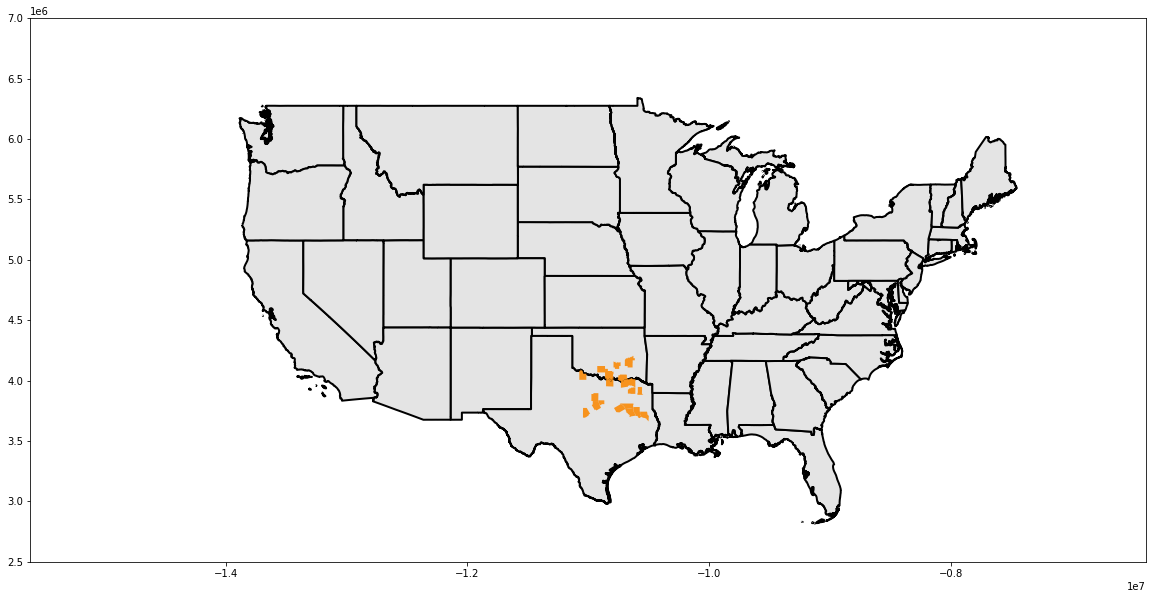

In [22]:
ax = plotUS()
gdf[gdf['liminal'] & gdf.intersects(dfwBuff)].plot(ax=ax, color='#f7931e')

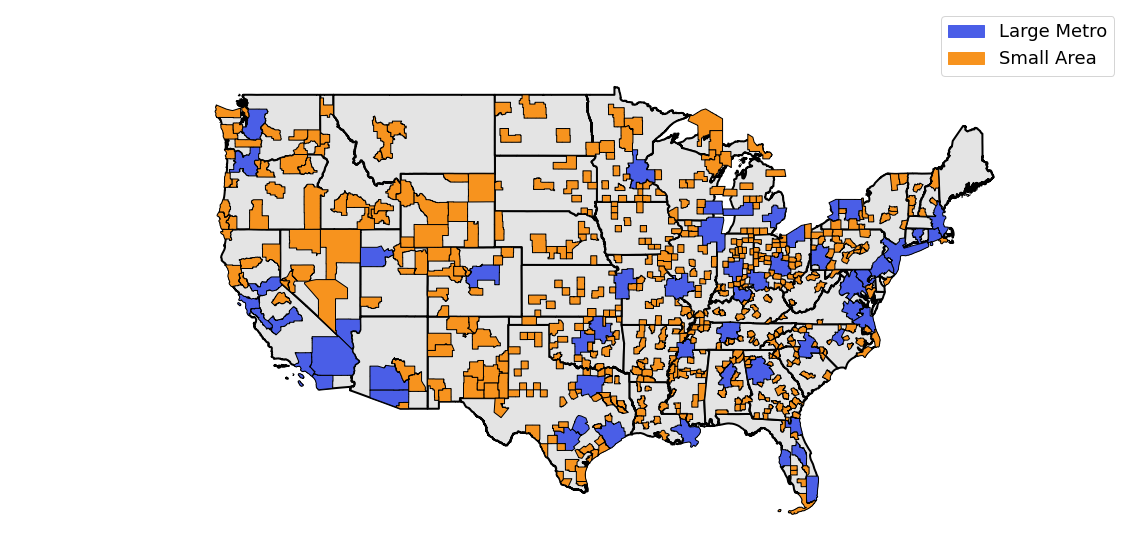

In [23]:
ax = plotUS()
gdf[gdf['metro']].plot(ax=ax, color="#4a5ee7", edgecolor="black", linewidth=1, label='Metro')
gdf[gdf['micro']].plot(ax=ax, color="#f7931e", edgecolor="black", linewidth=1, label='Micro')

plt.axis('off')

metro_patch = mpatches.Patch(color='#4a5ee7', label='Large Metro')
micro_patch = mpatches.Patch(color='#f7931e', label='Small Area')
# buff_patch = mpatches.Patch(color='green', alpha=0.3, label='Buffer')

plt.legend(handles=[metro_patch, micro_patch], loc='upper right', prop={'size': 18})
plt.savefig("figures/liminal_cities.png")

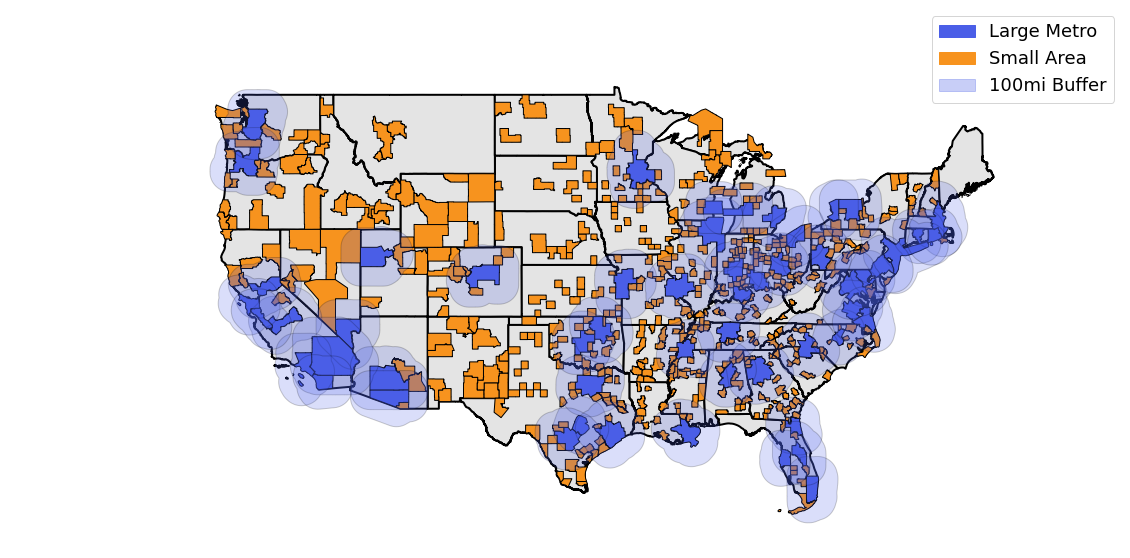

In [24]:
ax = plotUS()
gdf[gdf['metro']].plot(ax=ax, color="#4a5ee7", edgecolor="black", linewidth=1, label='Metro')
gdf[gdf['micro']].plot(ax=ax, color="#f7931e", edgecolor="black", linewidth=1, label='Micro')
gdf[gdf['metro']]['buff'].plot(ax=ax, color="#4a5ee7", edgecolor="black", linewidth=1, alpha=0.2, label='Buffer')

plt.axis('off')

metro_patch = mpatches.Patch(color='#4a5ee7', label='Large Metro')
micro_patch = mpatches.Patch(color='#f7931e', label='Small Area')
buff_patch = mpatches.Patch(color='#4a5ee7', alpha=0.3, label='100mi Buffer')

plt.legend(handles=[metro_patch, micro_patch, buff_patch], loc='upper right', prop={'size': 18})
plt.savefig("figures/liminal_cities 2.png")

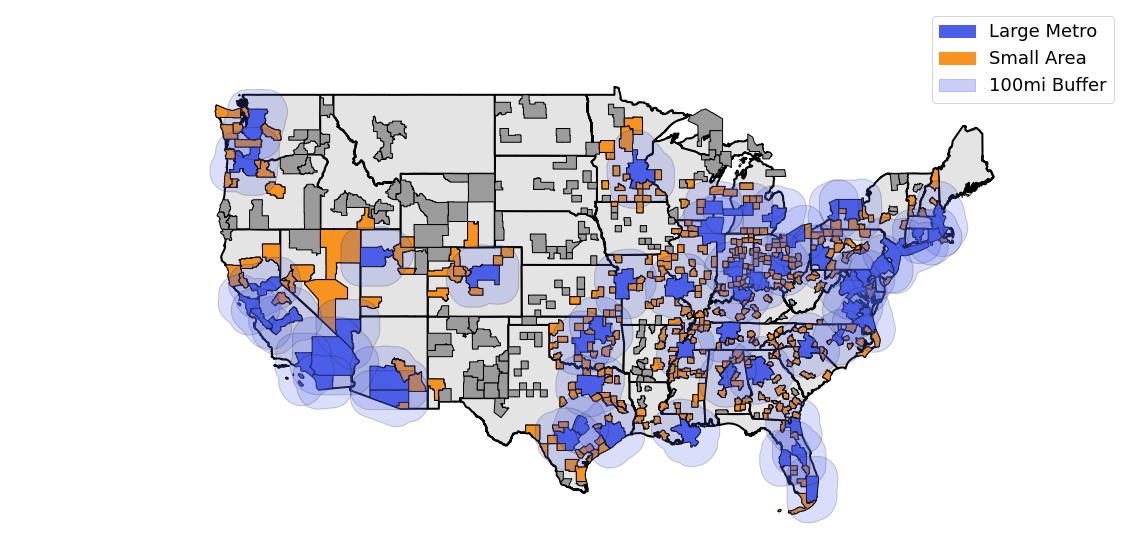

In [25]:
ax = plotUS()
gdf[gdf['metro']].plot(ax=ax, color="#4a5ee7", edgecolor="black", linewidth=1, label='Metro')
gdf[gdf['micro']].plot(ax=ax, color="#9b9b9b", edgecolor="black", linewidth=1, label='Micro')
gdf[gdf['micro'] & gdf['inBuff']].plot(ax=ax, color="#f7931e", edgecolor="black", linewidth=1)
gdf[gdf['metro']]['buff'].plot(ax=ax, color="#4a5ee7", edgecolor="black", linewidth=1, alpha=0.2, label='Buffer')

plt.axis('off')

metro_patch = mpatches.Patch(color='#4a5ee7', label='Large Metro')
micro_patch = mpatches.Patch(color='#f7931e', label='Small Area')
buff_patch = mpatches.Patch(color='#4a5ee7', alpha=0.3, label='100mi Buffer')

plt.legend(handles=[metro_patch, micro_patch, buff_patch], loc='upper right', prop={'size': 18})
plt.savefig("figures/liminal_cities 3.png")

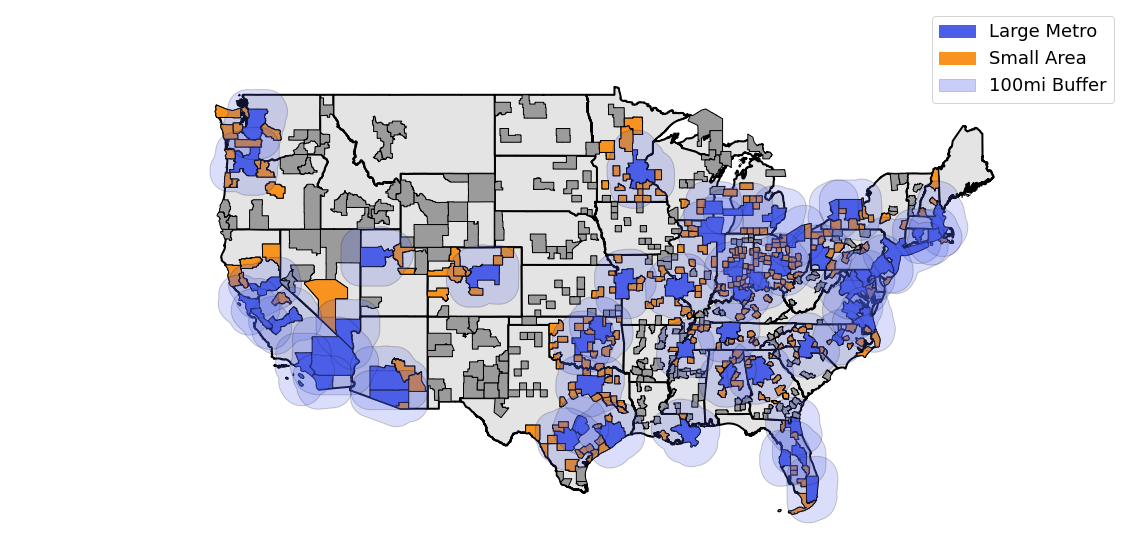

In [26]:
ax = plotUS()
gdf[gdf['metro']].plot(ax=ax, color="#4a5ee7", edgecolor="black", linewidth=1, label='Metro')
gdf[gdf['micro']].plot(ax=ax, color="#9b9b9b", edgecolor="black", linewidth=1, label='Micro')
gdf[gdf['liminal']].plot(ax=ax, color="#f7931e", edgecolor="black", linewidth=1)
gdf[gdf['metro']]['buff'].plot(ax=ax, color="#4a5ee7", edgecolor="black", linewidth=1, alpha=0.2, label='Buffer')

plt.axis('off')

metro_patch = mpatches.Patch(color='#4a5ee7', label='Large Metro')
micro_patch = mpatches.Patch(color='#f7931e', label='Small Area')
buff_patch = mpatches.Patch(color='#4a5ee7', alpha=0.3, label='100mi Buffer')

plt.legend(handles=[metro_patch, micro_patch, buff_patch], loc='upper right', prop={'size': 18})
plt.savefig("figures/liminal_cities 4.png")

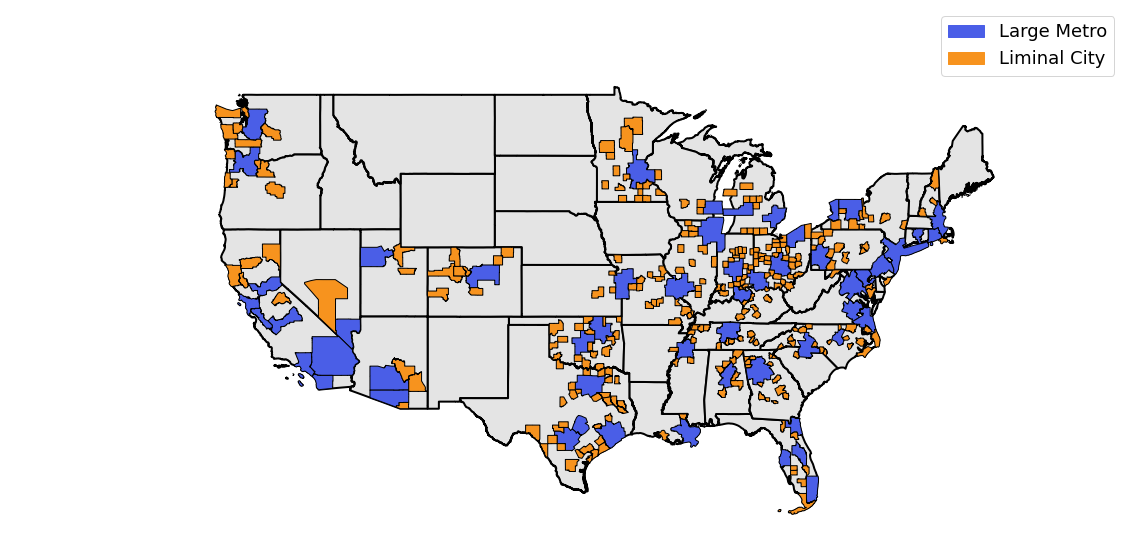

In [27]:
ax = plotUS()
gdf[gdf['metro']].plot(ax=ax, color="#4a5ee7", edgecolor="black", linewidth=1, label='Metro')
gdf[gdf['liminal']].plot(ax=ax, color="#f7931e", edgecolor="black", linewidth=1)

plt.axis('off')

metro_patch = mpatches.Patch(color='#4a5ee7', label='Large Metro')
micro_patch = mpatches.Patch(color='#f7931e', label='Liminal City')

plt.legend(handles=[metro_patch, micro_patch], loc='upper right', prop={'size': 18})

plt.savefig("figures/liminal_cities 5.png")

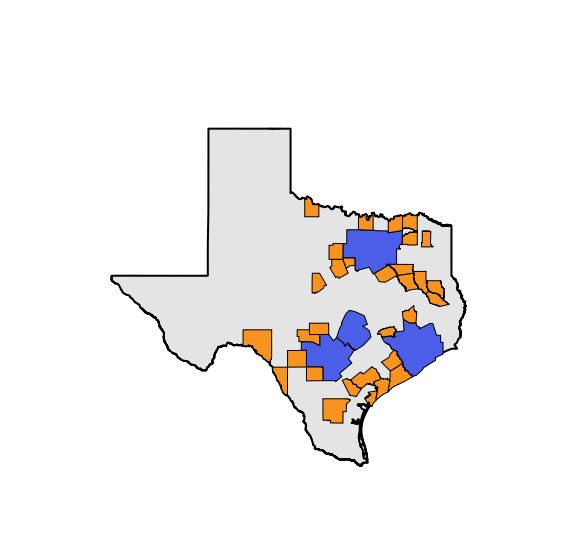

In [28]:
ax = plotTX()
gdf[gdf['metro'] & gdf['NAME'].str.contains(', TX')].plot(ax=ax, color="#4a5ee7", edgecolor="black", linewidth=1, label='Metro')
gdf[gdf['liminal'] & gdf['NAME'].str.contains(', TX')].plot(ax=ax, color="#f7931e", edgecolor="black", linewidth=1)

plt.axis('off')

plt.savefig("figures/liminal_cities tx.png")

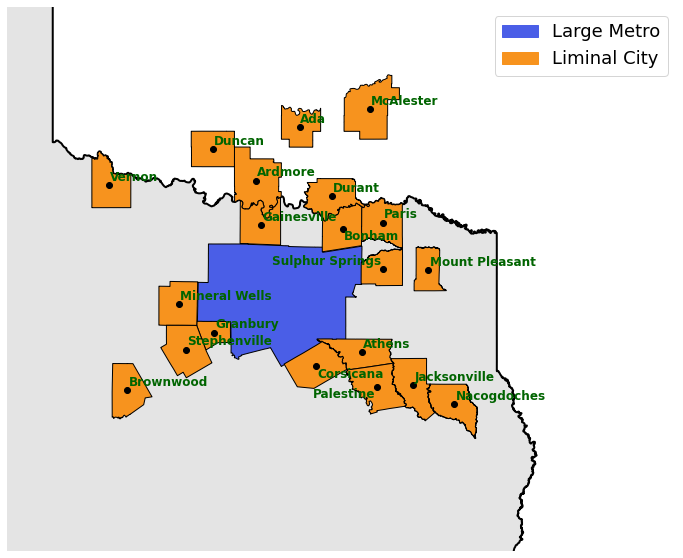

In [29]:
dfwMetro = gdf[gdf['CBSA'] == 19100]
gdfDfw = gdf[gdf.intersects(dfwMetro['buff'].iloc[0])]
dfwLiminal = gdfDfw[gdfDfw['liminal']]

ax = plotDFW()
dfwMetro.plot(ax=ax, color="#4a5ee7", edgecolor="black", linewidth=1, label='Metro')
dfwLiminal.plot(ax=ax, color="#f7931e", edgecolor="black", linewidth=1)

texts = []
for idx, row in dfwLiminal.iterrows():
    texts.append(plt.annotate(
        text=row['NAME'].split(',')[0],
        xy=row['geometry'].centroid.coords[0],
        horizontalalignment='left',
        color='darkgreen',
        fontweight='bold',
        fontsize='large'
    ))

plt.axis('off')

metro_patch = mpatches.Patch(color='#4a5ee7', label='Large Metro')
micro_patch = mpatches.Patch(color='#f7931e', label='Liminal City')

plt.legend(handles=[metro_patch, micro_patch], loc='upper right', prop={'size': 18})

dfwLiminal.centroid.plot(ax=ax, color='black')
adjust_text(texts, ax=ax)

plt.savefig("figures/liminal_cities dfw.png")

In [30]:
set(dfwLiminal['CBSA'])

{10220,
 11620,
 11980,
 14300,
 15220,
 18620,
 20340,
 20460,
 23620,
 24180,
 27380,
 32540,
 33420,
 34420,
 34860,
 37300,
 37580,
 44500,
 44860,
 46900}

In [31]:
#Possible liminal places
gdf[gdf['micro'] & gdf['inBuff']]

,CBSA,LSAD,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,NAME,geometry,metro,micro,buff,inBuff,liminal
40,14100,Metropolitan Statistical Area,82811,83083,83017,"Bloomsburg-Berwick, PA","POLYGON ((-8519061.832 4995028.114, -8519664.2...",False,True,"POLYGON ((-8703861.469 5047485.614, -8702949.8...",True,True
55,16020,Metropolitan Statistical Area,97543,97757,98275,"Cape Girardeau, MO-IL","POLYGON ((-9961838.624 4474214.320, -9961852.4...",False,True,"POLYGON ((-10204289.337 4461721.058, -10204279...",True,True
57,16180,Metropolitan Statistical Area,58683,58796,58130,"Carson City, NV","POLYGON ((-13358818.121 4745421.344, -13358481...",False,True,"POLYGON ((-13519739.565 4743411.040, -13519179...",True,False
80,18020,Metropolitan Statistical Area,82216,82730,83540,"Columbus, IN","POLYGON ((-9582568.992 4753144.806, -9582570.1...",False,True,"POLYGON ((-9743795.054 4765690.912, -9743803.3...",True,True
83,18700,Metropolitan Statistical Area,95208,96277,97630,"Corvallis, OR","POLYGON ((-13712559.689 5577560.652, -13712027...",False,True,"POLYGON ((-13900969.796 5404979.803, -13905684...",True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
915,48980,Micropolitan Statistical Area,78807,78283,78449,"Wilson, NC","POLYGON ((-8687152.660 4271423.319, -8687035.7...",False,True,"POLYGON ((-8760491.542 4414769.800, -8759083.7...",True,True
916,49060,Micropolitan Statistical Area,34524,34652,34453,"Winfield, KS","POLYGON ((-10814782.844 4481524.994, -10814783...",False,True,"POLYGON ((-10975722.800 4496289.469, -10975829...",True,False
918,49100,Micropolitan Statistical Area,49640,49750,49478,"Winona, MN","POLYGON ((-10250133.062 5468589.383, -10250142...",False,True,"POLYGON ((-10411146.478 5444622.209, -10411146...",True,True
920,49260,Micropolitan Statistical Area,24145,23947,23647,"Woodward, OK","POLYGON ((-11088048.834 4382492.709, -11088049...",False,True,"POLYGON ((-11292928.554 4361880.674, -11293299...",True,True


## How many people commute to a nearby large metro area?

In [32]:
def countCommuteBuff(row):
    count = 0
    microId = row['CBSA']
    for _, metro in gdf[gdf['metro']].iterrows():
        if metro['buff'].intersects(row['geometry']):
            metroId = metro['CBSA']
            try:
                count += odTable[microId, metroId]
            except KeyError:
                pass
    return count

gdf['commuteBuffCount'] = gdf.apply(countCommuteBuff, axis=1)
gdf['workingPop'] = gdf['CBSA'].apply(lambda cbsa: workingPop.get(cbsa, float('nan')))
gdf['commutePercent'] = gdf['commuteBuffCount'] / gdf['workingPop'] * 100
gdf

,CBSA,LSAD,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,NAME,geometry,metro,micro,buff,inBuff,liminal,commuteBuffCount,workingPop,commutePercent
0,10180,Metropolitan Statistical Area,176866,177829,179308,"Abilene, TX","POLYGON ((-11148262.500 3832132.455, -11148249...",False,False,"POLYGON ((-11309677.340 3783320.344, -11309649...",True,False,7146.0,66780.0,10.700809
1,10420,Metropolitan Statistical Area,701625,696225,697627,"Akron, OH","POLYGON ((-9060481.928 5063847.837, -9060475.5...",False,False,"POLYGON ((-9254365.317 5020257.954, -9254364.7...",True,False,86722.0,306288.0,28.313875
2,10500,Metropolitan Statistical Area,148244,144922,145786,"Albany, GA","POLYGON ((-9400975.184 3713776.408, -9400980.6...",False,False,"POLYGON ((-9578772.815 3741602.731, -9578761.8...",True,False,3686.0,50430.0,7.309141
3,10540,Metropolitan Statistical Area,128978,129948,130467,"Albany-Lebanon, OR","POLYGON ((-13720236.776 5551262.937, -13720393...",False,False,"POLYGON ((-13880404.968 5518947.795, -13880524...",True,False,6390.0,54728.0,11.675925
4,10580,Metropolitan Statistical Area,899748,905369,904617,"Albany-Schenectady-Troy, NY","POLYGON ((-8247992.807 5305256.748, -8248085.6...",False,False,"POLYGON ((-8472736.168 5278351.957, -8472566.1...",True,False,25289.0,390058.0,6.483395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,49300,Micropolitan Statistical Area,116906,116129,116559,"Wooster, OH","POLYGON ((-9089178.853 5010653.858, -9088979.1...",False,False,"POLYGON ((-9303427.427 5003041.204, -9303435.5...",True,False,8380.0,48312.0,17.345587
922,49380,Micropolitan Statistical Area,22207,22047,21947,"Worthington, MN","POLYGON ((-10627927.538 5441934.306, -10627791...",False,True,"POLYGON ((-10853572.863 5404615.190, -10853573...",False,False,0.0,9763.0,0.000000
923,49460,Micropolitan Statistical Area,23282,23334,23373,"Yankton, SD","POLYGON ((-10855702.126 5337734.746, -10853435...",False,True,"POLYGON ((-11029881.460 5334892.015, -11029883...",False,False,0.0,10222.0,0.000000
924,49780,Micropolitan Statistical Area,86450,86574,86113,"Zanesville, OH","POLYGON ((-9149881.580 4868949.855, -9149879.9...",False,True,"POLYGON ((-9314594.513 4866712.033, -9313763.6...",True,True,10044.0,33194.0,30.258480


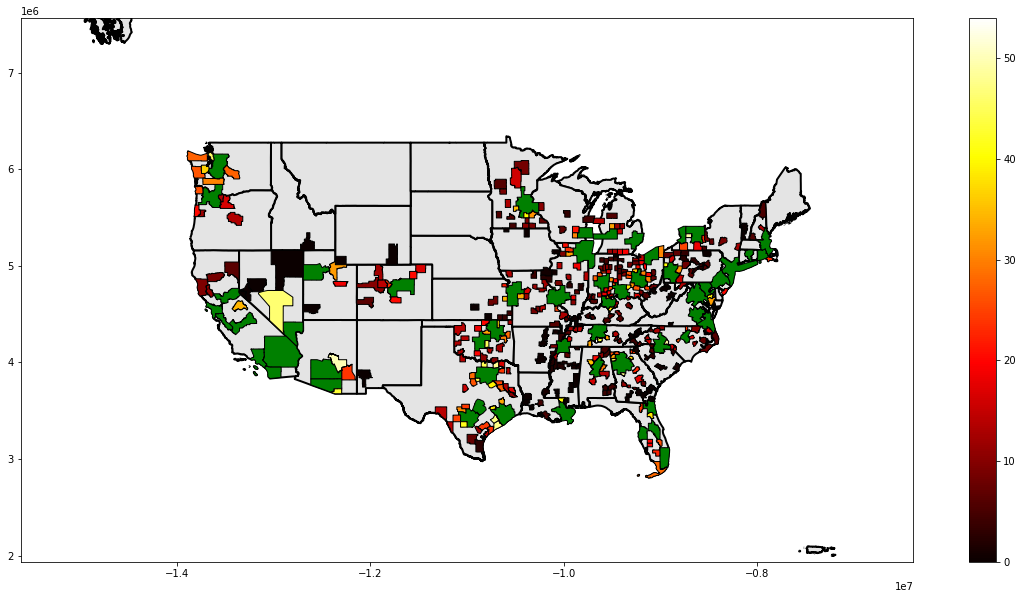

In [33]:
ax = plotUS()
gdf[gdf['metro']].plot(ax=ax, color="green", edgecolor="black", linewidth=1)
gdf[gdf['micro'] & gdf['inBuff']].plot(column='commutePercent', ax=ax, edgecolor="black", linewidth=1, legend=True, cmap="hot");
plt.savefig("figures/commute_percent.png")

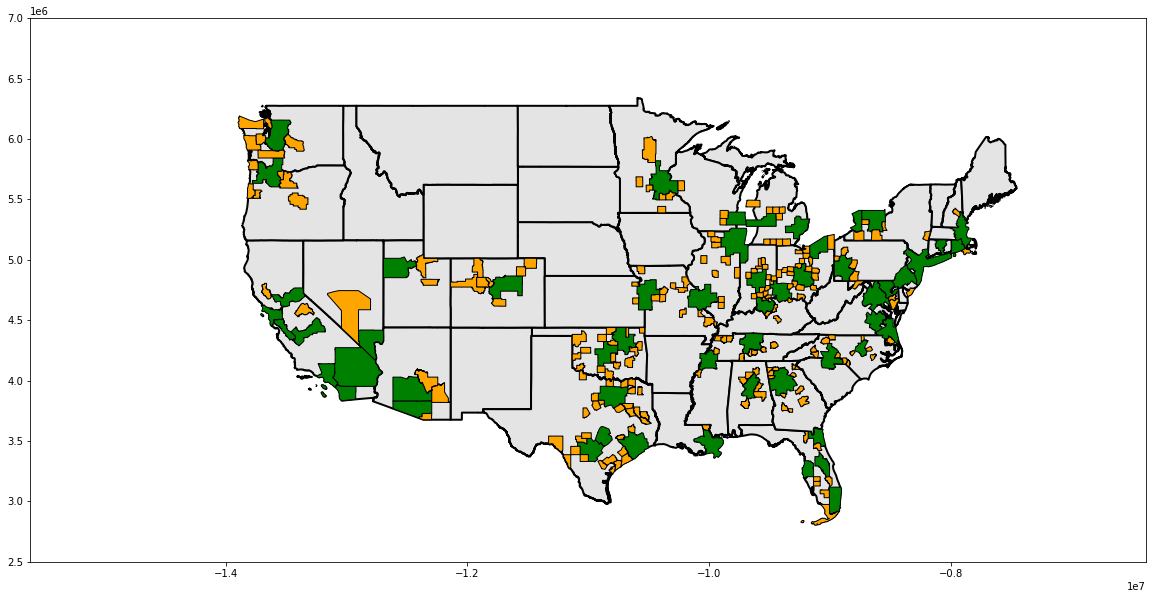

In [34]:
ax = plotUS()
gdf[gdf['metro']].plot(ax=ax, color="green", edgecolor="black", linewidth=1)
gdf[gdf['micro'] & gdf['inBuff'] & (gdf['commutePercent'] > 10)].plot(ax=ax, color="orange", edgecolor="black", linewidth=1);

In [35]:
gdf[gdf['micro'] & gdf['inBuff'] & (gdf['commutePercent'] > 50)]

,CBSA,LSAD,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,NAME,geometry,metro,micro,buff,inBuff,liminal,commuteBuffCount,workingPop,commutePercent
657,30280,Micropolitan Statistical Area,34466,35032,35878,"Lewisburg, TN","POLYGON ((-9656148.347 4259945.427, -9656134.2...",False,True,"POLYGON ((-9839819.840 4241653.123, -9839921.9...",True,True,8024.0,14862.0,53.990042


In [36]:
gdf['liminal'] = gdf['micro'] & gdf['inBuff'] & (gdf['commutePercent'] > 5)
gdf[gdf['liminal']]

,CBSA,LSAD,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,NAME,geometry,metro,micro,buff,inBuff,liminal,commuteBuffCount,workingPop,commutePercent
40,14100,Metropolitan Statistical Area,82811,83083,83017,"Bloomsburg-Berwick, PA","POLYGON ((-8519061.832 4995028.114, -8519664.2...",False,True,"POLYGON ((-8703861.469 5047485.614, -8702949.8...",True,True,1927.0,33115.0,5.819115
55,16020,Metropolitan Statistical Area,97543,97757,98275,"Cape Girardeau, MO-IL","POLYGON ((-9961838.624 4474214.320, -9961852.4...",False,True,"POLYGON ((-10204289.337 4461721.058, -10204279...",True,True,5162.0,39310.0,13.131519
80,18020,Metropolitan Statistical Area,82216,82730,83540,"Columbus, IN","POLYGON ((-9582568.992 4753144.806, -9582570.1...",False,True,"POLYGON ((-9743795.054 4765690.912, -9743803.3...",True,True,7463.0,36721.0,20.323521
83,18700,Metropolitan Statistical Area,95208,96277,97630,"Corvallis, OR","POLYGON ((-13712559.689 5577560.652, -13712027...",False,True,"POLYGON ((-13900969.796 5404979.803, -13905684...",True,True,4119.0,35081.0,11.741398
85,19060,Metropolitan Statistical Area,94845,94557,94122,"Cumberland, MD-WV","POLYGON ((-8801760.132 4790581.946, -8801685.8...",False,True,"POLYGON ((-8970534.174 4836474.975, -8969084.6...",True,True,3477.0,26194.0,13.274032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,48940,Micropolitan Statistical Area,42023,42100,41964,"Wilmington, OH","POLYGON ((-9349247.979 4789969.020, -9349247.7...",False,True,"POLYGON ((-9512041.540 4770858.170, -9511961.1...",True,True,6807.0,17784.0,38.275978
915,48980,Micropolitan Statistical Area,78807,78283,78449,"Wilson, NC","POLYGON ((-8687152.660 4271423.319, -8687035.7...",False,True,"POLYGON ((-8760491.542 4414769.800, -8759083.7...",True,True,5497.0,32229.0,17.056068
918,49100,Micropolitan Statistical Area,49640,49750,49478,"Winona, MN","POLYGON ((-10250133.062 5468589.383, -10250142...",False,True,"POLYGON ((-10411146.478 5444622.209, -10411146...",True,True,1382.0,20277.0,6.815604
920,49260,Micropolitan Statistical Area,24145,23947,23647,"Woodward, OK","POLYGON ((-11088048.834 4382492.709, -11088049...",False,True,"POLYGON ((-11292928.554 4361880.674, -11293299...",True,True,1375.0,9604.0,14.316951


# Export Results

In [37]:
# gdf.to_pickle(sharedFolder + 'gdf20' + LODESYear + '.pkl')

# Interactive Maps

In [11]:
#Alternative to running above code if results are already exported
gdf = pd.read_pickle('/work/group/egodat/reu23_clark/gdf20' + LODESYear + '.pkl')

In [12]:
contUS = ['AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
tooltip = ['CBSA', 'NAME', 'LSAD', 'POPESTIMATE2021', 'commuteBuffCount', 'workingPop', 'commutePercent']

def addTitleLegend(m, title, legend, titleTop=10):
    m.get_root().html.add_child(folium.Element(f"""
    <div style="position: absolute; top: {titleTop}px; left: 50%; transform: translateX(-50%); font-size: 24px; font-weight: bold; z-index: 500">{title}</div>

    <div style="position: absolute; bottom: 50px; left: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px; border-radius: 5px; border: 1px solid black; z-index: 500">
    """ + "\n".join(f"""
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <span style="display: inline-block; width: 20px; height: 20px; margin-right: 5px; background-color: {color};"></span>
        <span>{name}</span>
      </div>
    """ for name, color in legend.items()) + """
    </div>
    """))

In [13]:
m = statesShp[statesShp['STUSPS'].isin(contUS)].explore(style_kwds=dict(
    weight=1,
    fill=False
))
m = gdf[gdf['metro']]['buff'].explore(m=m, color="green", style_kwds=dict(
    weight=1,
    fillOpacity=0.2
))
m = gdf[gdf['metro']].explore(m=m, color="green", tooltip=tooltip)
m = gdf[gdf['micro'] & gdf['inBuff']].explore(m=m, color="orange", tooltip=tooltip)
folium.LayerControl().add_to(m)

addTitleLegend(m, "Metro/Micro Areas and Buffers", {
    'Metro Area > 1M': 'green',
    'Metro/Micro < 100K': 'orange',
    '100Mi Buffer': '#c2d9bb'
})

m.save("figures/map.html")
# m

In [14]:
m = statesShp[statesShp['STUSPS'].isin(contUS)].explore(style_kwds=dict(
    weight=1,
    fill=False
))
m = gdf[gdf['metro']].explore(m=m, color="green", tooltip=tooltip)
m = gdf[gdf['micro'] & gdf['inBuff']].explore(m=m, column='commutePercent', cmap='hot', tooltip=tooltip)
folium.LayerControl().add_to(m)

addTitleLegend(m, "Percent Commuting to Large Metro Area", {
    'Metro Area > 1M': 'green'
}, titleTop=50)

m.save("figures/map2_" + LODESYear + ".html")
# m

In [15]:
m = statesShp[statesShp['STUSPS'].isin(contUS)].explore(style_kwds=dict(
    weight=1,
    fill=False
))
m = gdf[gdf['metro']].explore(m=m, color="green", tooltip=tooltip)
m = gdf[gdf['micro'] & gdf['inBuff'] & (gdf['commutePercent'] > 5)].explore(m=m, color="yellow", tooltip=tooltip)
m = gdf[gdf['micro'] & gdf['inBuff'] & (gdf['commutePercent'] > 10)].explore(m=m, color="orange", tooltip=tooltip)
folium.LayerControl().add_to(m)

addTitleLegend(m, "Liminal Areas 5%/10% Commuting", {
    'Metro Area > 1M': 'green',
    '5%-10% Commuting': 'yellow',
    '>10% Commuting': 'orange'
})


m.save("figures/map3_" + LODESYear + ".html")
# m